# Fire Forest Detection - How to

The goal of this notebook is to show how to train a classification model based on transfer learning.

__Pre-requisite__: The test images and the model's weights have to be downloaded (see data.ipynb notebook)

In [1]:
import os
import numpy as np
import tensorflow as tf

import tl_utils
import tl_models
import tl_train

## Google drive connection (optional)

The google drive connection is useful to save automaticaly the results of the train/validation/test to the goolgle drive

Initialize google drive to save the results

## Hyper paramters definition

Get one model from the tl_models library.

In [2]:
hyper_params = tl_models.Xception_AdaptivePooling_512_64_3_Adadelta_0_block1

hyper_params is composed of:

config_id: a unique id of the configuration (during the training a directory with the name of the config is created)

In [3]:
hyper_params['config_id']

'Xception_AdaptivePooling_512_64_3_Adadelta_0_block1'

data: information about the data (i.e. batch_size, resolution, data augmentation parameters)

In [4]:
hyper_params['data']

{'repo': 'big',
 'categories': {0: 'fire', 1: 'no_fire', 2: 'start_fire'},
 'resolution': (224, 224),
 'batch_size': 10,
 'train_generator': {'with_data_augmentation': True,
  'rotation_range': 20,
  'width_shift_range': 0.2,
  'height_shift_range': 0.2,
  'shear_range': 0.2,
  'horizontal_flip': True,
  'zoom_range': 0.1}}

model: network parameters (i.e. base model of transfer learning, the strucuture of the classifier)

In [5]:
hyper_params['model']

{'base_model': 'Xception',
 'link_to_classifier': 'global_adaptive_pooling2D',
 'base_model_output_normalization': True,
 'base_model_output_dropout': 0.2,
 'classifier_topology': [{'name': 'FC_1',
   'nbr_nodes': 512,
   'normalization': True,
   'activation': 'relu',
   'dropout': 0.2},
  {'name': 'FC_2',
   'nbr_nodes': 64,
   'normalization': True,
   'activation': 'relu',
   'dropout': 0.2}]}

training_steps: list of training steps information: (freeze the layer, max number of epochs, optimizer parameters, ...)

Remark: Before the training step, we will freeze all the first layers until to detect a layer with an id starting with the *freeze_until_layer_id* parameter. 

In [6]:
hyper_params['training_steps']

[{'freeze_until_layer_id': 'block1',
  'max_epochs': 200,
  'patience': 10,
  'optimizer': {'class_id': 'Adadelta', 'args': {'learning_rate': 0.001}}}]

## Data generator

In [7]:
train_generator, validation_generator = tl_train.create_generators(hyper_params['data'])

Found 4365 images belonging to 3 classes.
Found 1099 images belonging to 3 classes.


Check the generators and display several images

In [8]:
x_step, y_step = train_generator.next()
assert x_step.shape[0] == hyper_params['data']['batch_size']
assert x_step.shape[1] == hyper_params['data']['resolution'][0]
assert x_step.shape[2] == hyper_params['data']['resolution'][1]
assert x_step.shape[3] == 3            # R,G,B channels

assert y_step.shape[0] == hyper_params['data']['batch_size']
assert y_step.shape[1] == len(hyper_params['data']['categories'])
x_step.shape, y_step.shape

((10, 224, 224, 3), (10, 3))

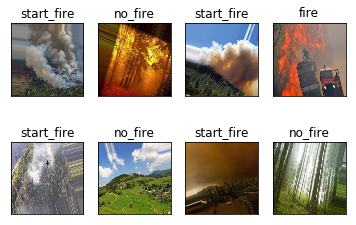

In [9]:
tl_utils.display_samples(train_generator, hyper_params['data']['categories'])

## Build model based on transfer learning

Remark: the layers are not freezed at this step.

In [10]:
model = tl_train.build_model(hyper_params['model'], len(hyper_params['data']['categories']), hyper_params['data']['resolution'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

## Train a model

In [23]:
results = tl_train.train_analyse(hyper_params, 'results', 'small')

Found 593 images belonging to 3 classes.
Found 198 images belonging to 3 classes.
Epoch 1/2
12/12 [==============================] - 764s 64s/step - loss: 1.0897 - acc: 0.4030 - val_loss: 1.0742 - val_acc: 0.4141
Epoch 2/2
12/12 [==============================] - 634s 53s/step - loss: 1.0430 - acc: 0.4992 - val_loss: 1.0347 - val_acc: 0.4949
Epoch 3/4
12/12 [==============================] - 580s 48s/step - loss: 1.0232 - acc: 0.4840 - val_loss: 1.0237 - val_acc: 0.4949
Epoch 4/4
12/12 [==============================] - 568s 47s/step - loss: 1.0089 - acc: 0.5396 - val_loss: 1.0138 - val_acc: 0.5000


# Evaluation using test images

In [24]:
test_dir = os.path.join('test_images_with_classes')
test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator( rescale = 1.0/255. )
test_generator =  test_datagen.flow_from_directory(
    test_dir,
    batch_size=hyper_params['data']['batch_size'],
    class_mode  = 'categorical',
    target_size = hyper_params['data']['resolution'])


Found 100 images belonging to 3 classes.


Load the best model

In [28]:
best_model_file = os.path.join('results', hyper_params['config_id'], results['optimal_model'])
best_model = tf.keras.models.load_model(best_model_file)

In [29]:
prediction = best_model.evaluate_generator(test_generator, verbose=1)
prediction

2/2 [==============================] - 34s 17s/step - loss: 1.0463 - acc: 0.4600


[1.046267032623291, 0.46]

In [47]:
bad_classified = tl_utils.scan_and_classify_image(best_model, test_dir, hyper_params['data']['categories'])

start_fire   - test_images_with_classes/fire/test29.jpg ([0.32442516 0.2544376  0.4211372 ])
fire         - test_images_with_classes/fire/test12.jpg ([0.5028053  0.20348775 0.29370704])
start_fire   - test_images_with_classes/fire/test38.jpg ([0.3741124  0.20831625 0.41757137])
fire         - test_images_with_classes/fire/test11.jpg ([0.4473138  0.1992216  0.35346463])
fire         - test_images_with_classes/fire/test39.jpg ([0.48511654 0.2988529  0.2160305 ])
fire         - test_images_with_classes/fire/test6.jpg ([0.39207786 0.2960163  0.31190583])
fire         - test_images_with_classes/fire/test89.jpg ([0.44539478 0.20917995 0.34542525])
fire         - test_images_with_classes/fire/test62.jpg ([0.5507386  0.20632735 0.24293405])
fire         - test_images_with_classes/fire/test88.jpg ([0.4537531  0.29396114 0.2522857 ])
fire         - test_images_with_classes/fire/test48.jpg ([0.43191183 0.26174113 0.30634707])
fire         - test_images_with_classes/fire/test4.jpg ([0.45831153 0.2

start_fire   - test_images_with_classes/start_fire/test69.jpg ([0.35624838 0.2088036  0.43494794])
fire         - test_images_with_classes/start_fire/test41.jpg ([0.4763634  0.19401479 0.32962176])
fire         - test_images_with_classes/start_fire/test9.jpg ([0.46889895 0.22683653 0.30426452])
fire         - test_images_with_classes/start_fire/test92.jpg ([0.41389823 0.29184133 0.2942604 ])
fire         - test_images_with_classes/start_fire/test50.jpg ([0.5083658  0.14668533 0.3449489 ])
fire         - test_images_with_classes/start_fire/test87.jpg ([0.43228766 0.25397542 0.31373686])
fire         - test_images_with_classes/start_fire/test52.jpg ([0.4476049  0.2285208  0.32387426])
fire         - test_images_with_classes/start_fire/test53.jpg ([0.4382392  0.24554703 0.3162138 ])
fire         - test_images_with_classes/start_fire/test90.jpg ([0.47133303 0.24878225 0.27988467])
fire         - test_images_with_classes/start_fire/test84.jpg ([0.5211647  0.15417336 0.32466194])
fire       

inspect the bad classified images

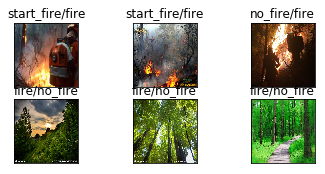

In [48]:
tl_utils.display_images_with_class(bad_classified[:6], img_columns=3)

## Dump the data to Google Drive (optional)